In [1]:
import pandas as pd
import numpy as np

In [2]:
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt')
df = pd.concat([df1,df2])
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,7035249,2384833
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,2384840
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,2384875
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,2384951
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,2385020


In [25]:
#Convert Date and Time into a more useable DateTime format.
def df_DateTime(df):
    df['DateTime'] = pd.to_datetime(df.DATE+' '+df.TIME)
    return df

#Record what day of the week each entry is from
def df_day_of_week(df):
    df['Day']=df.DateTime.dt.day_name()
    return df

#SCP represents a specific turnstile.
#C/A represents a control area. This is a bank of turnstiles.  
#Unit represents a remote unit. Usually a whole station, or an area in a complex station.
#We can combine all three to create a unique ID for any turnstile
def df_Unit_ID(df):
    df['Unit_ID'] = df.SCP+' '+df['C/A']+' '+df.UNIT
    return df

#Rename Exits column to remove extra spaces
def rename_columns(df):
    df.rename(columns={'EXITS                                                               ':'EXITS'},inplace=True)
    return df

#Remove irregularities in reporting
def clean_desc(df):
    df = df[df.DESC == 'REGULAR']
    return df

#Calculate the entries/exits in a four hour period by finding the difference between rows
def df_four_hour(df):
    df['Four Hour Entries'] = df.groupby('Unit_ID').ENTRIES.diff()
    df['Four Hour Exits'] = df.groupby('Unit_ID').EXITS.diff()
    return df

#Replace NaN, negative values, and impossibly large values by the average of the turnstile
def df_clean_four_hour(df):
    df['Four Hour Entries'].fillna(-1, inplace=True)
    df['Four Hour Exits'].fillna(-1, inplace=True)
    df['Four Hour Entries'] = df.groupby(['TIME','C/A'])['Four Hour Entries'].transform(
        lambda x: np.where((x<0)|(x>20000),x.mask((x<0)|(x>20000)).mean(),x))
    df['Four Hour Exits'] = df.groupby(['TIME','C/A'])['Four Hour Exits'].transform(
        lambda x: np.where((x<0)|(x>20000),x.mask((x<0)|(x>20000)).mean(),x))
    return df

#Create a column for the total amount of traffic through a turnstile
def df_total_flow(df):
    df['Total Flow'] = df['Four Hour Entries']+df['Four Hour Exits']
    return df

IndentationError: unexpected indent (<ipython-input-25-511256c6ec88>, line 23)

In [16]:
df1 = df_DateTime(df1)
df1 = df_day_of_week(df1)
df1 = df_Unit_ID(df1)
df1 = rename_columns(df1)
df1 = df_four_hour(df1)
df1 = df_clean_four_hour(df1)
df1 = clean_desc(df1)
df1 = df_total_flow(df1)
df1.head()

<ipython-input-15-91586f5ad53e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateTime'] = pd.to_datetime(df.DATE+' '+df.TIME)
<ipython-input-15-91586f5ad53e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day']=df.DateTime.dt.day_name()
<ipython-input-15-91586f5ad53e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DateTime,Day,Unit_ID,Four Hour Entries,Four Hour Exits,Total Flow
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,00:00:00,REGULAR,7035249,2384833,2019-04-27 00:00:00,Saturday,02-00-00 A002 R051,149.152778,49.111111,198.263889
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,04:00:00,REGULAR,7035269,2384840,2019-04-27 04:00:00,Saturday,02-00-00 A002 R051,20.000000,7.000000,27.000000
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,08:00:00,REGULAR,7035292,2384875,2019-04-27 08:00:00,Saturday,02-00-00 A002 R051,23.000000,35.000000,58.000000
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,12:00:00,REGULAR,7035392,2384951,2019-04-27 12:00:00,Saturday,02-00-00 A002 R051,100.000000,76.000000,176.000000
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/27/2019,16:00:00,REGULAR,7035651,2385020,2019-04-27 16:00:00,Saturday,02-00-00 A002 R051,259.000000,69.000000,328.000000


In [26]:
#Find daily sum for each STATION for each day of the week
df1_daily = df1.groupby(['STATION','DATE'])['Four Hour Entries','Four Hour Exits','Total Flow'].sum()
df1_daily.head(20)

<ipython-input-26-9aec250956d1>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1_daily = df1.groupby(['STATION','DATE'])['Day','Four Hour Entries','Four Hour Exits','Total Flow'].sum()


Four Hour Entries  Four Hour Exits  Total Flow
STATION       DATE                                                      
1 AV          04/27/2019        6611.333333      9176.666667     15788.0
              04/28/2019        5205.000000      7239.000000     12444.0
              04/29/2019       17134.000000     19320.000000     36454.0
              04/30/2019       18588.000000     20421.000000     39009.0
              05/01/2019       19221.000000     21124.000000     40345.0
              05/02/2019       19406.000000     21335.000000     40741.0
              05/03/2019       19732.000000     22665.000000     42397.0
103 ST        04/27/2019       19351.000000     13987.000000     33338.0
              04/28/2019       15913.000000     12349.000000     28262.0
              04/29/2019       30243.000000     21166.000000     51409.0
              04/30/2019       32303.000000     21440.000000     53743.0
              05/01/2019       32706.000000     22290.000000     54996.0
              05/02/2019       32849.000000     22354.000000     55203.0
              05/03/2019       32740.000000     21646.000000     54386.0
103 ST-CORONA 04/27/2019       14378.000000     11945.500000     26323.5
              04/28/2019       11415.000000     10283.000000     21698.0
              04/29/2019       19903.000000     12769.000000     32672.0
              04/30/2019       19854.000000     14780.000000     34634.0
              05/01/2019       20265.000000     13799.000000     34064.0
              05/02/2019       20693.000000     14936.000000     35629.0

In [67]:
df1_daily.sort_values(by=['Total Flow'],ascending=False).head(60)

Four Hour Entries  Four Hour Exits     Total Flow
STATION         DATE                                                         
34 ST-PENN STA  05/02/2019      177841.476190    160361.410714  338202.886905
                05/01/2019      177733.476190    159379.410714  337112.886905
                05/03/2019      169801.476190    158841.410714  328642.886905
                04/30/2019      174815.476190    153589.410714  328404.886905
                04/29/2019      169283.913690    146943.098214  316227.011905
GRD CNTRL-42 ST 05/01/2019      165304.071340    141747.924143  307051.995483
                05/02/2019      163527.355124    142631.302521  306158.657645
                04/30/2019      162523.355124    139958.302521  302481.657645
                05/03/2019      156925.355124    136269.949580  293195.304704
                04/29/2019      150529.258633    132881.184874  283410.443507
34 ST-HERALD SQ 05/03/2019      125888.987302    117832.000000  243720.987302
                05/02/2019      124792.653968    118410.000000  243202.653968
                05/01/2019      124479.987302    116378.000000  240857.987302
                04/30/2019      121956.987302    112160.000000  234116.987302
                04/29/2019      113923.765079    106299.000000  220222.765079
14 ST-UNION SQ  05/02/2019      116460.000000    101153.000000  217613.000000
                05/03/2019      109138.000000    101029.000000  210167.000000
TIMES SQ-42 ST  05/01/2019      108617.680272     97424.000000  206041.680272
14 ST-UNION SQ  04/30/2019      105320.000000     99042.000000  204362.000000
TIMES SQ-42 ST  05/02/2019      106554.680272     97725.000000  204279.680272
                05/03/2019      106188.680272     97400.000000  203588.680272
14 ST-UNION SQ  05/01/2019      102808.000000    100222.000000  203030.000000
23 ST           05/01/2019      119121.000000     81053.000000  200174.000000
FULTON ST       05/02/2019      107693.000000     89805.000000  197498.000000
                05/01/2019      107041.000000     89351.000000  196392.000000
23 ST           05/02/2019      115025.000000     81153.000000  196178.000000
TIMES SQ-42 ST  04/30/2019       99265.680272     95438.000000  194703.680272
23 ST           04/30/2019      114729.000000     79820.000000  194549.000000
                04/29/2019      108906.700000     85045.000000  193951.700000
14 ST-UNION SQ  04/29/2019       98367.000000     93882.000000  192249.000000
23 ST           05/03/2019      112981.000000     76326.000000  189307.000000
34 ST-PENN STA  04/27/2019       93953.886905     94933.214286  188887.101190
42 ST-PORT AUTH 05/03/2019      102202.380952     85064.568783  187266.949735
FULTON ST       05/03/2019      102931.000000     84287.000000  187218.000000
                04/30/2019      100822.000000     84903.000000  185725.000000
42 ST-PORT AUTH 05/01/2019      102406.380952     83130.124339  185536.505291
                05/02/2019      102638.714286     82693.235450  185331.949735
TIMES SQ-42 ST  04/29/2019       95418.680272     87906.000000  183324.680272
FULTON ST       04/29/2019       98773.000000     83385.000000  182158.000000
42 ST-PORT AUTH 04/30/2019       99421.047619     79639.124339  179060.171958
86 ST           05/01/2019       90840.082251     85675.381914  176515.464165
                05/03/2019       90156.264069     85411.179894  175567.443963
42 ST-PORT AUTH 04/29/2019       98399.047619     76221.235450  174620.283069
86 ST           05/02/2019       90350.264069     83588.624339  173938.888408
                04/30/2019       90173.478146     82065.748483  172239.226629
34 ST-PENN STA  04/28/2019       90368.476190     79483.410714  169851.886905
86 ST           04/29/2019       82854.264069     76346.291005  159200.555075
CANAL ST        04/30/2019       81614.607143     68150.000000  149764.607143
125 ST          05/02/2019       83020.334737     66352.000000  149372.334737
                05/03/2019       82005.968926     

In [31]:
 %matplotlib inline
import matplotlib.pyplot as plt

In [57]:
test = df1.loc[df1['Unit_ID']=='02-00-00 A002 R051'].groupby('DATE')['Total Flow'].sum()
test


DATE
04/27/2019    1116.263889
04/28/2019     861.000000
04/29/2019    1913.000000
04/30/2019    1943.000000
05/01/2019    2031.000000
05/02/2019    2083.000000
05/03/2019    2049.000000
Name: Total Flow, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

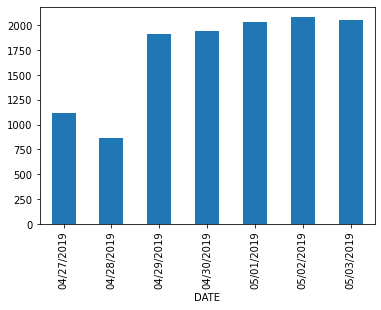

In [56]:
test.plot(x='date', y='counts',kind="bar")
plt.show

In [63]:
test2 = df1.groupby(['DATE','STATION','C/A','UNIT'])['Total Flow'].sum()
test2.sort_values(ascending=False).head(20)

DATE        STATION          C/A    UNIT
05/01/2019  PATH NEW WTC     PTH22  R540    125234.000000
05/02/2019  PATH NEW WTC     PTH22  R540    124383.000000
04/30/2019  PATH NEW WTC     PTH22  R540    119375.000000
04/29/2019  PATH NEW WTC     PTH22  R540    115043.000000
05/03/2019  PATH NEW WTC     PTH22  R540    109095.000000
05/01/2019  GRD CNTRL-42 ST  R238   R046     98129.302521
05/02/2019  GRD CNTRL-42 ST  R238   R046     96354.302521
04/30/2019  GRD CNTRL-42 ST  R238   R046     95970.302521
04/29/2019  GRD CNTRL-42 ST  R238   R046     90481.184874
05/01/2019  34 ST-PENN STA   R138   R293     80707.886905
05/02/2019  FLUSHING-MAIN    R533   R055     80398.000000
            34 ST-PENN STA   R138   R293     79856.886905
05/01/2019  FLUSHING-MAIN    R533   R055     79435.000000
04/30/2019  FLUSHING-MAIN    R533   R055     79029.000000
05/03/2019  FLUSHING-MAIN    R533   R055     78756.000000
04/30/2019  34 ST-PENN STA   R138   R293     78640.886905
05/03/2019  34 ST-PENN STA   R1

In [62]:
test3 = df1.groupby(['DATE','STATION'])['Total Flow'].sum()
test3.sort_values(ascending=False).head(20)

DATE        STATION        
05/02/2019  34 ST-PENN STA     338202.886905
05/01/2019  34 ST-PENN STA     337112.886905
05/03/2019  34 ST-PENN STA     328642.886905
04/30/2019  34 ST-PENN STA     328404.886905
04/29/2019  34 ST-PENN STA     316227.011905
05/01/2019  GRD CNTRL-42 ST    307051.995483
05/02/2019  GRD CNTRL-42 ST    306158.657645
04/30/2019  GRD CNTRL-42 ST    302481.657645
05/03/2019  GRD CNTRL-42 ST    293195.304704
04/29/2019  GRD CNTRL-42 ST    283410.443507
05/03/2019  34 ST-HERALD SQ    243720.987302
05/02/2019  34 ST-HERALD SQ    243202.653968
05/01/2019  34 ST-HERALD SQ    240857.987302
04/30/2019  34 ST-HERALD SQ    234116.987302
04/29/2019  34 ST-HERALD SQ    220222.765079
05/02/2019  14 ST-UNION SQ     217613.000000
05/03/2019  14 ST-UNION SQ     210167.000000
05/01/2019  TIMES SQ-42 ST     206041.680272
04/30/2019  14 ST-UNION SQ     204362.000000
05/02/2019  TIMES SQ-42 ST     204279.680272
Name: Total Flow, dtype: float64

In [76]:
df1.loc[df1['STATION']=='PATH NEW WTC'].groupby('DATE')['Total Flow'].sum()

DATE
04/27/2019      4378.0
04/28/2019      3362.0
04/29/2019    115043.0
04/30/2019    119375.0
05/01/2019    125234.0
05/02/2019    124383.0
05/03/2019    109095.0
Name: Total Flow, dtype: float64

In [ ]:
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190518.txt')
df4 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190525.txt')
df5 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190601.txt')